In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline
# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv("../input/train.csv",
                   parse_dates=["datetime"])
train.shape 
test = pd.read_csv("../input/test.csv",
                   parse_dates=["datetime"])
test.shape


# Feature Engineering

# parsing datetime
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
# train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
# train['minute'] =train['datetime'].dt.minute
# train['second'] = train['datetime'].dt.second
train['dayofweek'] = train['datetime'].dt.second
train.shape # col_num : 12 > 18

test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
# test["day"] = test["datetime"].dt.day
test["hour"] = test["datetime"].dt.hour
# test["minute"] = test["datetime"].dt.minute
# test["second"] = test["datetime"].dt.second
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape

(6493, 13)

In [2]:
# 범주형 feature는 one-hot-encoding을 해주면 점수가 올라가지만, 
# 그렇게 차이가 없기 때문에 그대로 진행

categorical_feature_names = ["season","holiday","workingday","weather",
                             "dayofweek","month","year","hour"]
for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")
    
feature_names = ["season", "weather", "temp", "atemp", "humidity",
                 "year", "hour", "dayofweek", "holiday", "workingday"
                ]

feature_names   

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [3]:
# train set
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

# test set
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

# label

label_name = "count"

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886, 10)
(6493, 10)
(10886,)


0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

In [4]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values, convertExp=True):

    if convertExp:
        predicted_values = np.exp(predicted_values),
        actual_values = np.exp(actual_values)

    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)

    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)

    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    difference = np.square(difference)

    # 평균을 낸다.
    mean_difference = difference.mean()

    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)

    return score

# 선형회귀 모델 Linear Regression Model
* 선형회귀는 예측과 훈련 세트에 있는 타깃 y 사이의 평균 제곱 오차(MSE)를 최소화하는 파라미터 w와 b를 찾는다.
* 선형회귀 모델은 그래프에서 선을 뜻한다. 
* 선 가까이 혹은 멀리 위치한 점들이 훈련데이터를 나타낸다.

In [5]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 선형회귀 모델을 초기화
lModel = LinearRegression()

# 모델을 학습시킨다.
y_train_log = np.log1p(y_train) # 1을 더한수에 로그를 씌움
lModel.fit(X_train, y_train_log)

# 예측하고 정확도를 평가한다.
preds = lModel.predict(X_train)
print ("RMSLE Value For Linear Regression: ",
       rmsle(np.exp(y_train_log),np.exp(preds), False))
###############

RMSLE Value For Linear Regression:  0.9808566170790233


In [ ]:
preds

## 릿지 Regularization Model - Ridge
* 회귀를 위한 선형모델
* 가중치(w)의 모든 원소가 0에 가깝게 만들어 모든 피처가 주는 영향을 최소화(기울기를 작게 만듦)
* Regularization(규제)는 오버피팅(과대적합)이 되지 않도록 모델을 강제로 제한한다는 의미이다.
* max_iter(반복 실행하는 최대 횟수)는 3000을 넣어주었다. 

{'alpha': 0.01, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9808566139255058


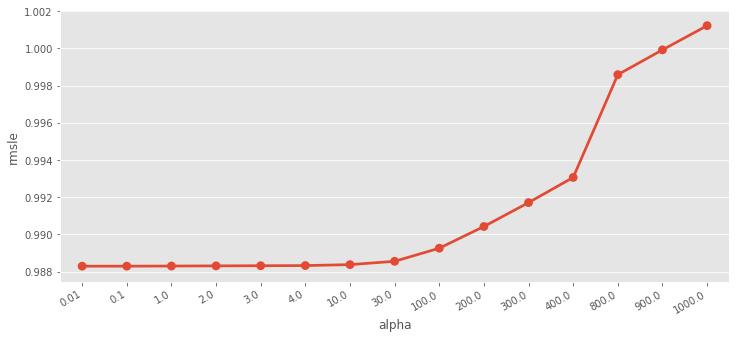

In [6]:
ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[3000],'alpha':[0.01, 0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV( ridge_m_,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5)

y_train_log = np.log1p(y_train)
grid_ridge_m.fit( X_train, y_train_log )
preds = grid_ridge_m.predict(X_train)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ", rmsle(np.exp(y_train_log),np.exp(preds), False))

fig,ax= plt.subplots()
fig.set_size_inches(12,5)
df = pd.DataFrame(grid_ridge_m.grid_scores_)
df["alpha"] = df["parameters"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_validation_score"].apply(lambda x:-x)

plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

## 라쏘 Regularization Model - Lasso
* 계수를 0에 가깝게 만들어 피쳐의 영향을 줄여준다. 자동 피처 선택 이라 볼 수 있다
* alpha 값의 기본값은 1.0이지만 과소적합을 줄이기 위해서는 이 값을 줄이는 것이 좋다. 

{'alpha': 0.001, 'max_iter': 3000}
RMSLE Value For Lasso Regression:  0.9808621547664045


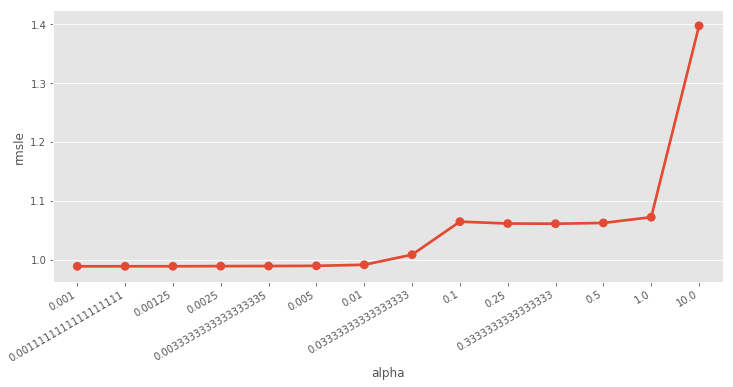

In [8]:
lasso_m_ = Lasso()

alpha  = 1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
lasso_params_ = { 'max_iter':[3000],'alpha':alpha}

grid_lasso_m = GridSearchCV( lasso_m_,lasso_params_,scoring = rmsle_scorer,cv=5)
y_train_log = np.log1p(y_train)
grid_lasso_m.fit( X_train , y_train_log )
preds = grid_lasso_m.predict(X_train)
print (grid_lasso_m.best_params_)
print ("RMSLE Value For Lasso Regression: ",rmsle(np.exp(y_train_log),np.exp(preds),False))

fig,ax= plt.subplots()
fig.set_size_inches(12,5)
df = pd.DataFrame(grid_lasso_m.grid_scores_)
df["alpha"] = df["parameters"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_validation_score"].apply(lambda x:-x)

plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

## 앙상블모델 - 랜덤포레스트

In [16]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)

y_train_log = np.log1p(y_train)
rfModel.fit(X_train, y_train_log)

preds = rfModel.predict(X_train)
score = rmsle(np.exp(y_train_log),np.exp(preds),False)
print ("RMSLE Value For Random Forest: ",score)

RMSLE Value For Random Forest:  0.12360308929195829


## 앙상블모델 - 그라디언트 부스트
* 여러 개의 결정 트리를 묶어 강력한 모델을 만드는 또 다른 앙상블 기법
* 회귀와 분류에 모두 사용할 수 있다. 
* 랜덤포레스트와 달리 이진 트리의 오차를 보완하는 방식으로 순차적으로 트리를 만든다. 
* 무작위성이 없고 강력한 사전 가지치기가 사용됨
* 1~5개의 깊지 않은 트리를 사용하기 때문에 메모리를 적게 사용하고 예측이 빠르다.
* learning_rate : 오차를 얼마나 강하게 보정할 것인지를 제어
* n_estimator의 값을 키우면 앙상블에 트리가 더 많이 추가되어 모델의 복잡도가 커지고 훈련 세트에서의 실수를 바로잡을 기회가 많아지지만, 너무 크면 모델이 복잡해지고 오버피팅이 일어날 수 있다.. 
* max_depth(max_leaf_nodes) 복잡도를 너무 높이지 말고 트리의 깊이가 5보다 깊어지지 않게 한다.


In [18]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000, alpha=0.01);

y_train_log = np.log1p(y_train)
gbm.fit(X_train, y_train_log)

preds = gbm.predict(X_train)
score = rmsle(np.exp(y_train_log),np.exp(preds),False)
print ("RMSLE Value For Gradient Boost: ", score)

RMSLE Value For Gradient Boost:  0.23716086306316173


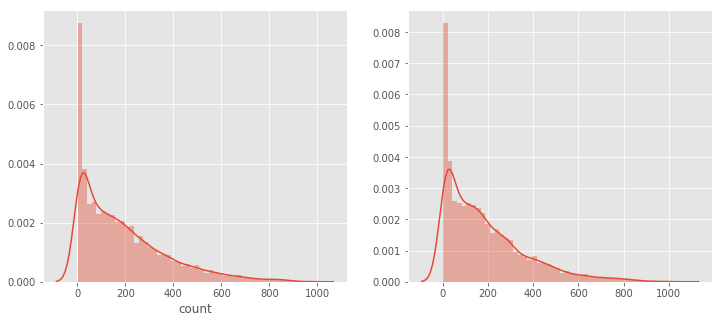

In [19]:
predsTest = gbm.predict(X_test)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
sns.distplot(np.exp(predsTest),ax=ax2,bins=50)

In [20]:
submission = pd.read_csv("../input/sampleSubmission.csv")
submission

submission["count"] = np.exp(predsTest)
print(submission.shape)

submission.to_csv("../output/Score_{0:.5f}_submission.csv".format(score), index=False)

(6493, 2)
